# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# Import numpy
import numpy as np

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
df_offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


### 1b. Explore the data

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
# your turn
# Count the unique offer in df_transactions
df_transactions.offer_id.nunique()

32

In [14]:
df_transactions.offer_id.value_counts().sort_index()

1     10
2     10
3      6
4     12
5      4
6     12
7     19
8     20
9     10
10     7
11    13
12     5
13     6
14     9
15     6
16     5
17     7
18    14
19     5
20     6
21     4
22    21
23     5
24    12
25     6
26    15
27     9
28     6
29    17
30    22
31    17
32     4
Name: offer_id, dtype: int64

In [16]:
# Good, all offers have a least one respondend. That is in df_transactions, there are all offers.
# Count number of customers
print(df_transactions.shape)
df_transactions.customer_name.nunique()

(324, 3)


100

In [27]:
# Make sure this dataframe has no duplicate()
duplicates = df_transactions.duplicated(keep=False)
df_transactions[duplicates]

,customer_name,offer_id,n


In [ ]:
# No duplicate in the dataset
# 100 customers, 32 offers. We will transpose dataframe df_transactions. The resulting one will have 100 rows x 33 columns
# But let use approach in Tier 1 notebook (cell below)

In [41]:
# your turn
# Think about calling merge() on df_transactions and df_offers
merged = pd.merge(df_transactions, df_offers) 
# Not having 'on' means to use common columns offer_id, not having 'how' means inner join. Resulting should have 324 rows

In [42]:
merged.shape

(324, 9)

In [47]:
merged.sort_values(['customer_name', 'offer_id']).head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
49,Adams,18,1,July,Espumante,6,50,Oregon,False
121,Adams,29,1,November,Pinot Grigio,6,87,France,False
139,Adams,30,1,December,Malbec,6,54,France,False
257,Allen,9,1,April,Chardonnay,144,57,Chile,False
283,Allen,27,1,October,Champagne,72,88,New Zealand,False


In [50]:
# We now want to make a pivot table
pivoted = merged.pivot(index='customer_name', columns='offer_id', values='n') 
# I think .pivot() does not have argument 'fill_value'). But .pivot_table() has. 

pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Wilson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Wood,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [54]:
help(pd.pivot)
# This shows our Pandas is old probably. There is no fill_value argument.

Help on function pivot in module pandas.core.reshape.pivot:

pivot(data: 'DataFrame', index: 'IndexLabel | None' = None, columns: 'IndexLabel | None' = None, values: 'IndexLabel | None' = None) -> 'DataFrame'
    Return reshaped DataFrame organized by given index / column values.
    
    Reshape data (produce a "pivot" table) based on column values. Uses
    unique values from specified `index` / `columns` to form axes of the
    resulting DataFrame. This function does not support data
    aggregation, multiple values will result in a MultiIndex in the
    columns. See the :ref:`User Guide <reshaping>` for more on reshaping.
    
    Parameters
    ----------
    data : DataFrame
    index : str or object or a list of str, optional
        Column to use to make new frame's index. If None, uses
        existing index.
    
        .. versionchanged:: 1.1.0
           Also accept list of index names.
    
    columns : str or object or a list of str
        Column to use to make new fra

In [56]:
# Fill NaN
pivoted.fillna(0, inplace=True)
pivoted.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
# Check Adams
pivoted.loc['Adams'].sort_values()

offer_id
1     0.0
28    0.0
27    0.0
26    0.0
25    0.0
24    0.0
23    0.0
22    0.0
21    0.0
20    0.0
19    0.0
17    0.0
31    0.0
15    0.0
16    0.0
13    0.0
2     0.0
3     0.0
4     0.0
5     0.0
14    0.0
7     0.0
6     0.0
9     0.0
10    0.0
11    0.0
12    0.0
8     0.0
32    0.0
18    1.0
29    1.0
30    1.0
Name: Adams, dtype: float64

In [20]:
# This is just question to the mentor. Why do we have to merge the two dataframes. We just need to pivot (transpose)
# the transactions dataframe as below.
test = pd.DataFrame({"A": ["foo", "foo", "foo", "bar", "bar"],
                   "offer_id": [1,2,4,3,5]})
test['n'] = 1
test

,A,offer_id,n
0,foo,1,1
1,foo,2,1
2,foo,4,1
3,bar,3,1
4,bar,5,1


In [24]:
table = pd.pivot_table(test, values='n', index='A', columns='offer_id', aggfunc=np.sum)
table

offer_id,1,2,3,4,5
A,,,,,
bar,NaN,NaN,1.0,NaN,1.0
foo,1.0,1.0,NaN,1.0,NaN


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [17]:
# your turn
import sklearn.cluster

# Make an empty list
ss = []

# Make an empty dictionary called assignments 
assignments = {}

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X 
X = pivoted.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

In [18]:
# Check the final dataframe and save to disk
pivoted.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [97]:
pivoted.shape

(100, 32)

In [98]:
# save to disk
pivoted.to_csv('pivoted.csv')

In [65]:
X[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [66]:
Krange

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [19]:
# Why we have to calculate ss below? why just use inertia_
ss_inertia = []

In [20]:
# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    ss_inertia.append(model.inertia_)
    assignments[str(K)] = assigned_cluster

In [21]:
ss

[251.91666666666669,
 227.55739795918367,
 212.67135531135534,
 203.2475,
 195.80515873015872,
 187.78018931551543,
 180.30975180769983,
 174.57437562437565,
 168.1200818789054]

In [22]:
ss_inertia
# the two lists are a little difference

[251.91666666666666,
 227.55739795918367,
 212.67135531135528,
 203.24749999999995,
 195.80515873015875,
 187.7801893155154,
 180.30975180769983,
 174.57437562437562,
 168.1200818789054]

In [72]:
# See the latest model parameters
model.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 10,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [73]:
model.n_iter_

5

In [75]:
print(model.n_features_in_)

32


Text(0, 0.5, 'Sum of Squares')

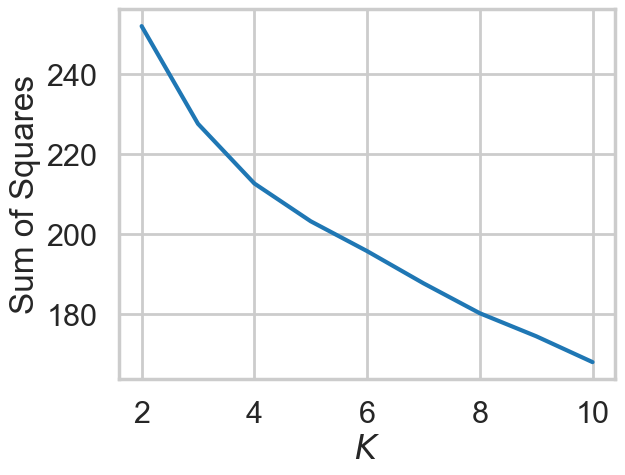

In [23]:
# Call plot() on plt with parameters Krange and ss
plt.plot(Krange, ss)

# Let's label the plot 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

# Can you see what we're doing here? 

In [81]:
assignments

{'2': array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]),
 '3': array([0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 2, 0, 0,
        2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2,
        0, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 1,
        1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 2, 1, 0, 0, 0, 2,
        0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2]),
 '4': array([1, 0, 3, 1, 2, 2, 3, 1, 2, 1, 2, 3, 1, 2, 0, 3, 0, 3, 1, 2, 1, 1,
        2, 2, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 3, 3, 1, 2,
        1, 2, 1, 0, 0, 0, 0, 2, 0, 3, 2, 1, 3, 0, 1, 2, 2, 1, 0, 1, 1, 3,
        3, 0, 2, 0, 0, 0, 2, 1, 2, 1, 3, 2, 1, 0, 0, 0, 0, 3, 1, 1, 1, 0,
     

In [85]:
assignments['9']

array([2, 1, 4, 5, 0, 0, 4, 3, 3, 5, 7, 4, 5, 7, 7, 4, 8, 4, 5, 0, 5, 3,
       3, 7, 4, 1, 1, 8, 1, 4, 5, 2, 7, 6, 5, 2, 7, 5, 7, 2, 4, 4, 3, 8,
       5, 6, 5, 5, 1, 7, 7, 0, 7, 4, 0, 3, 4, 5, 2, 3, 0, 3, 8, 2, 2, 1,
       4, 1, 0, 1, 1, 1, 0, 5, 0, 5, 4, 3, 2, 4, 1, 1, 1, 4, 2, 2, 5, 1,
       1, 3, 6, 2, 1, 5, 0, 0, 2, 0, 6, 0])

In [84]:
assignments.keys()

dict_keys(['2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [89]:
unique, frequency = np.unique(assignments['9'], return_counts=True)

In [91]:
frequency

array([13, 16, 12, 10, 15, 16,  4, 10,  4], dtype=int64)

<BarContainer object of 9 artists>

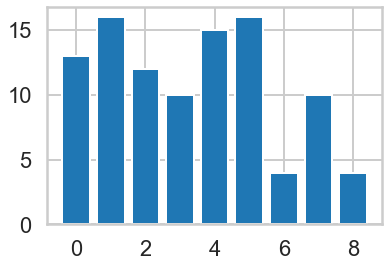

In [90]:
plt.bar(unique, frequency)

In [ ]:
# The below use np.bincount(). This is better than np.unique() above since np.unique() will NOT count the numbers that are not 
# in the list; but np.bincount() will count them as zero occurences.

9


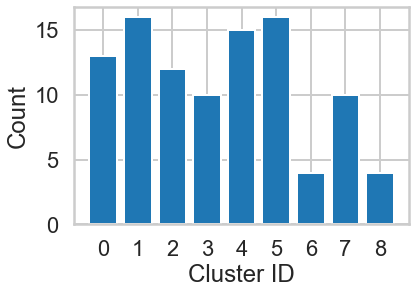

In [93]:
# What is the best K? Fill in the assignment below appropriately
best_K = 9
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts)) 

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
plt.bar(range(best_K), counts, align='center')

# Label the axes 
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(range(best_K))

In [94]:
counts

array([13, 16, 12, 10, 15, 16,  4, 10,  4], dtype=int64)

In [ ]:
These are questions that need to answer?
What values of 𝑆𝑆 do you believe represent better clusterings? Why?
What challenges did you experience using the Elbow method to pick 𝐾?
- Answer: There are two elbows in this picture (first time I run). There is no clear elbow the second time I run the model.  

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [8]:
# Need to restart computer and now read back lasted dataframe pivoted
pivoted = pd.read_csv('pivoted.csv', index_col=0)
pivoted.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
pivoted.shape

(100, 32)

In [10]:
# Recreate matrix X
# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X 
X = pivoted.to_numpy()

In [12]:
# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

In [14]:
import sklearn.cluster

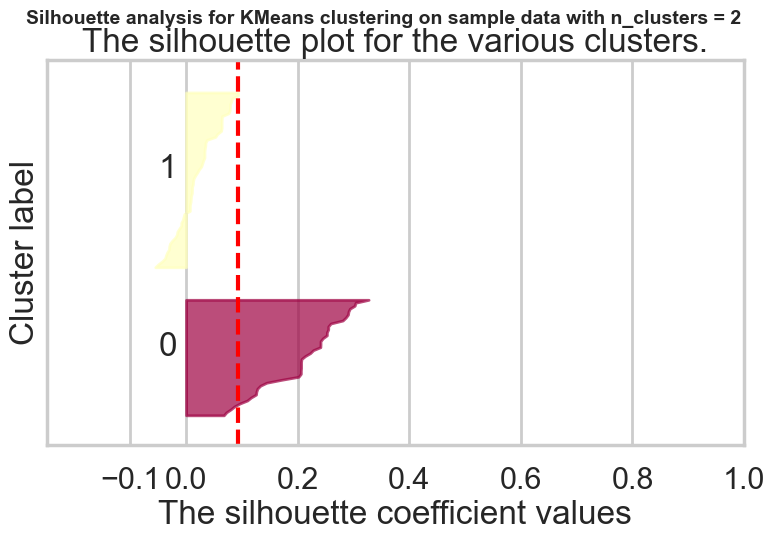

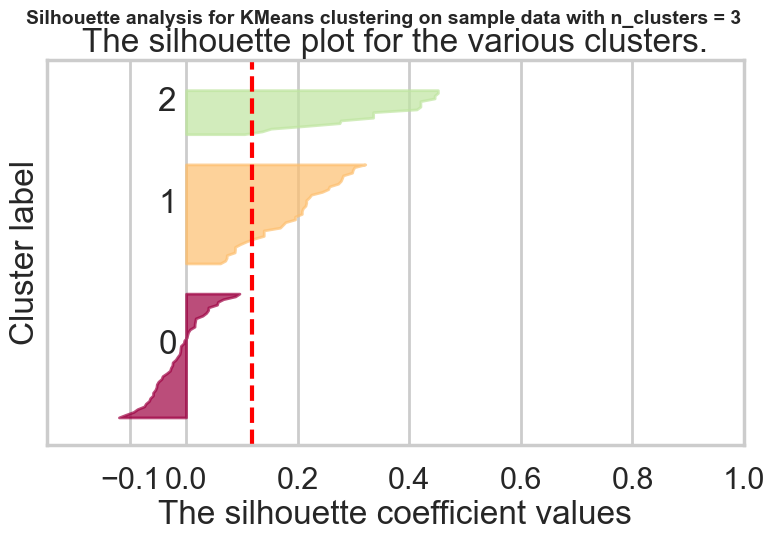

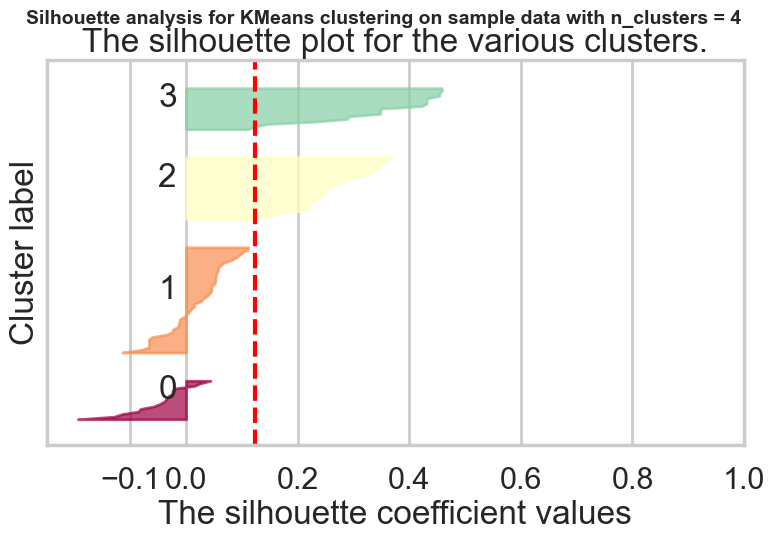

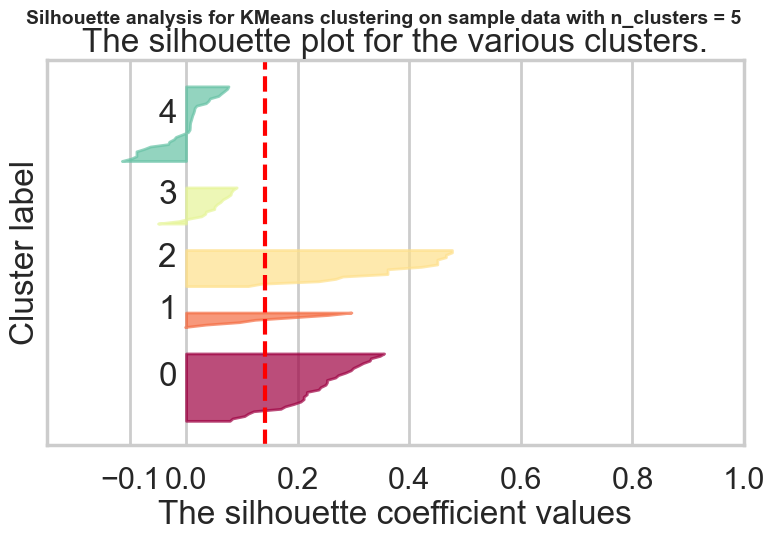

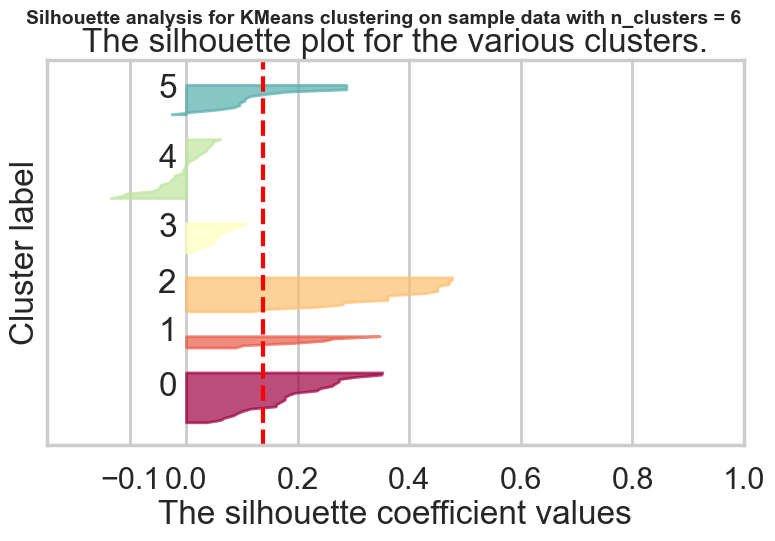

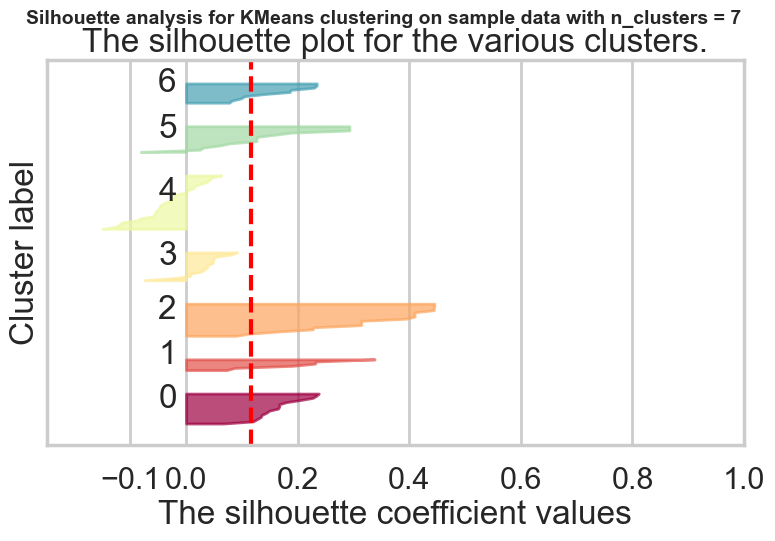

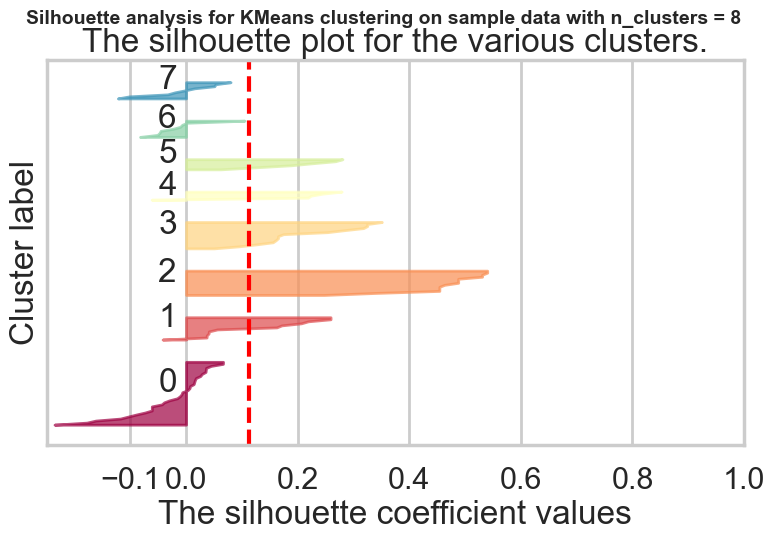

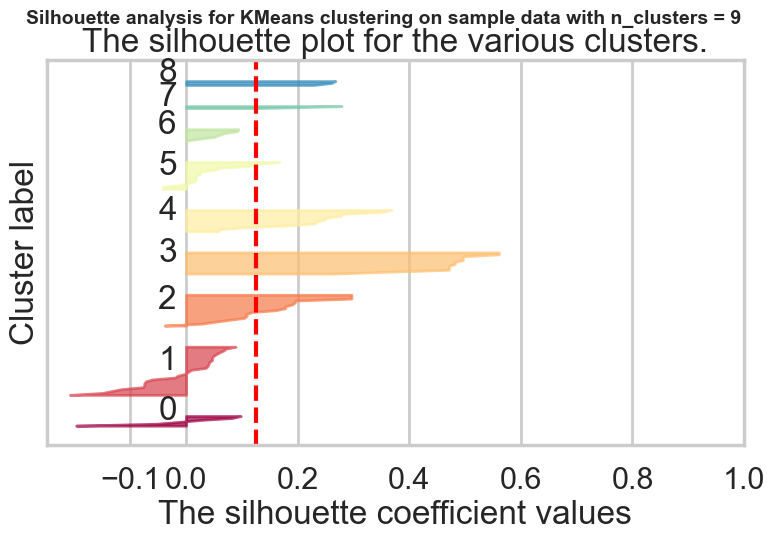

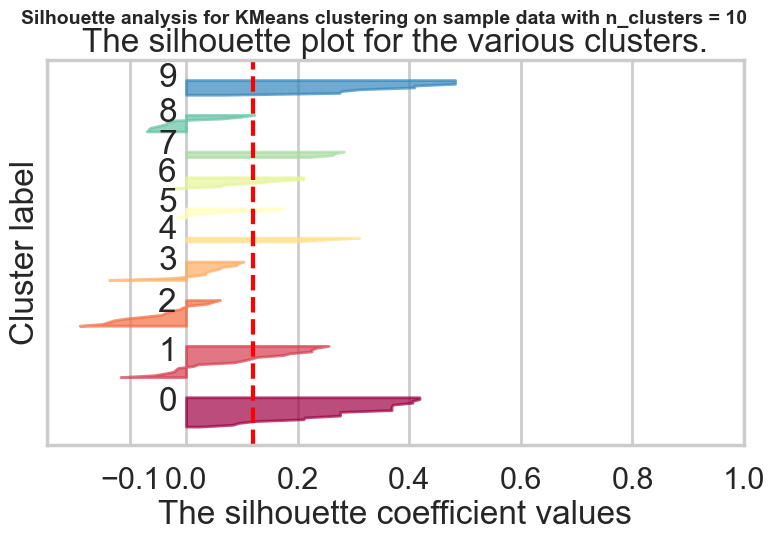

In [15]:
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')


In [ ]:
SOLUTIONS: Compute the average silhouette score for each  𝐾  and plot it. 
What  𝐾  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

Text(0, 0.5, 'Average Silhouette Score')

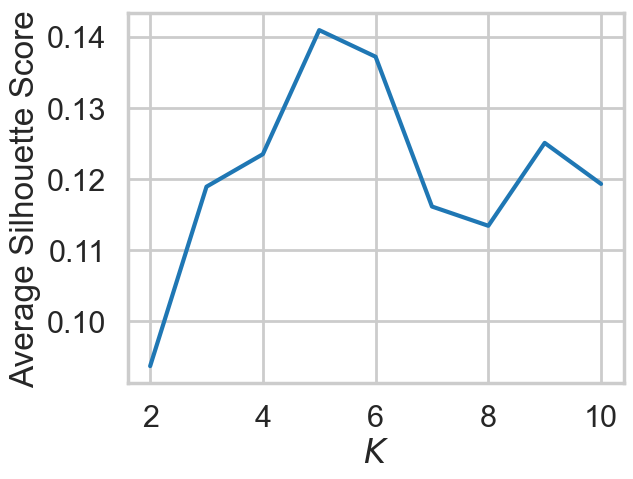

In [16]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

In [ ]:
# What can you conclude?
# Exercise: Compute the average silhouette score for each  𝐾  and plot it. 
# What  𝐾  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

Answer: Average Silhouette Score is very low. This suggests there is no clusters in the data.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [24]:
help(sklearn.decomposition)

Help on package sklearn.decomposition in sklearn:

NAME
    sklearn.decomposition

DESCRIPTION
    The :mod:`sklearn.decomposition` module includes matrix decomposition
    algorithms, including among others PCA, NMF or ICA. Most of the algorithms of
    this module can be regarded as dimensionality reduction techniques.

PACKAGE CONTENTS
    _base
    _cdnmf_fast
    _dict_learning
    _factor_analysis
    _fastica
    _incremental_pca
    _kernel_pca
    _lda
    _nmf
    _online_lda_fast
    _pca
    _sparse_pca
    _truncated_svd
    setup
    tests (package)

CLASSES
    sklearn.base.BaseEstimator(builtins.object)
        sklearn.decomposition._dict_learning.DictionaryLearning(sklearn.decomposition._dict_learning._BaseSparseCoding, sklearn.base.BaseEstimator)
        sklearn.decomposition._dict_learning.MiniBatchDictionaryLearning(sklearn.decomposition._dict_learning._BaseSparseCoding, sklearn.base.BaseEstimator)
        sklearn.decomposition._dict_learning.SparseCoder(sklearn.dec

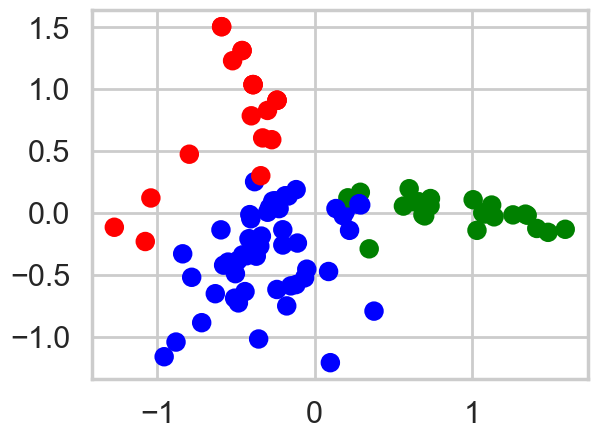

In [26]:
#your turn
import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

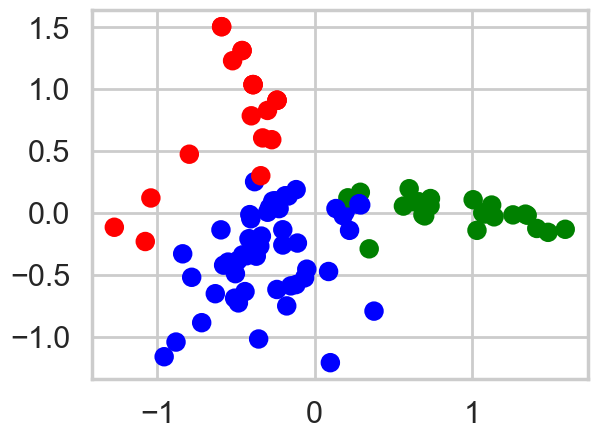

In [29]:
# What we are doing here: zip(*pca.fit_transform(X))
# Why we need to use .tolist() in this plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
# Let plot different way
transformed = pca.fit_transform(X)
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys, c=cluster_assignments.tolist(), cmap=cmap)
# So cmap=cmap is to use our own colormap; without it the collor is assigned by Python. 
# Not sure why we need to use .tolist() since it does not make difference.

In [31]:
# What we are doing here: pc1, pc2 = zip(*pca.fit_transform(X))
transformed.shape
# Here you have two columns since you specify n_components =2 

(100, 2)

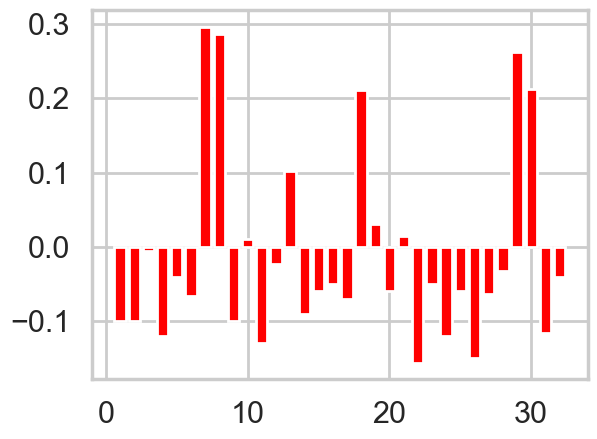

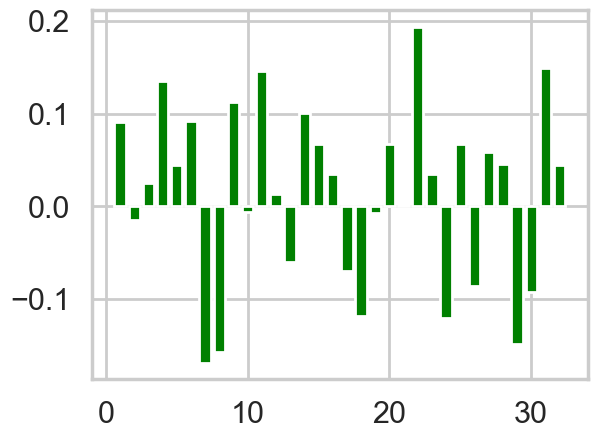

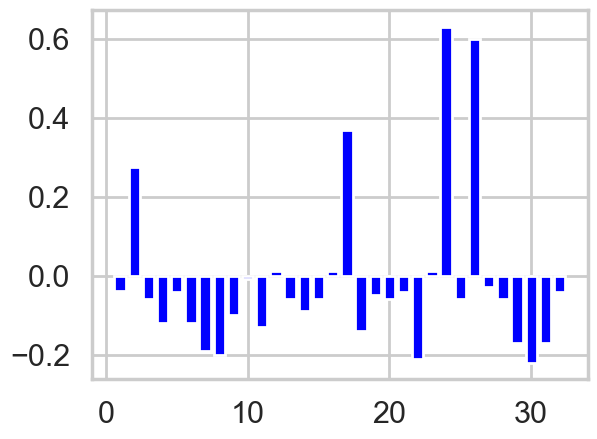

In [48]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers. The resulting has length of 32 offers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions # lift has lenght of 32 offers
    plt.bar(range(1, 33), lift, color=colors[i]) # range(1,33) because we plot lift for each of 32 offers

In [59]:
# We can look at numbers of offers by clusters
summary = pd.concat([pivoted[cluster_assignments == 0].sum(axis=0), pivoted[cluster_assignments == 1].sum(axis=0),
                      pivoted[cluster_assignments == 2].sum(axis=0)], axis=1)
summary.shape

(32, 3)

In [60]:
summary

,0,1,2
1,0.0,9.0,1.0
2,0.0,4.0,6.0
3,2.0,4.0,0.0
4,0.0,12.0,0.0
5,0.0,4.0,0.0
6,2.0,10.0,0.0
7,18.0,1.0,0.0
8,18.0,2.0,0.0
9,0.0,10.0,0.0
10,3.0,3.0,1.0


In [66]:
# Other way to look at numbers of offers by clusters
cluster_assignments.shape

(100,)

In [70]:
cluster_assgn = cluster_assignments.reshape(100, -1)

In [71]:
summary_1 = np.concatenate((cluster_assgn, X), axis=1)

In [73]:
summary_1.shape

(100, 33)

In [74]:
summary_1 = pd.DataFrame(summary_1)
summary_1.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [77]:
summary_1.groupby(0).sum().T

,0.0,1.0,2.0
1,0.0,9.0,1.0
2,0.0,4.0,6.0
3,2.0,4.0,0.0
4,0.0,12.0,0.0
5,0.0,4.0,0.0
6,2.0,10.0,0.0
7,18.0,1.0,0.0
8,18.0,2.0,0.0
9,0.0,10.0,0.0
10,3.0,3.0,1.0


In [80]:
# Or try pivot_table()
pd.pivot_table(summary_1, columns=0, aggfunc='sum')

,0.0,1.0,2.0
1,0.0,9.0,1.0
2,0.0,4.0,6.0
3,2.0,4.0,0.0
4,0.0,12.0,0.0
5,0.0,4.0,0.0
6,2.0,10.0,0.0
7,18.0,1.0,0.0
8,18.0,2.0,0.0
9,0.0,10.0,0.0
10,3.0,3.0,1.0


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [81]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

PCA()

In [82]:
pca.n_components_

32

Text(0.5, 1.0, 'Magnitude of Variance Explained')

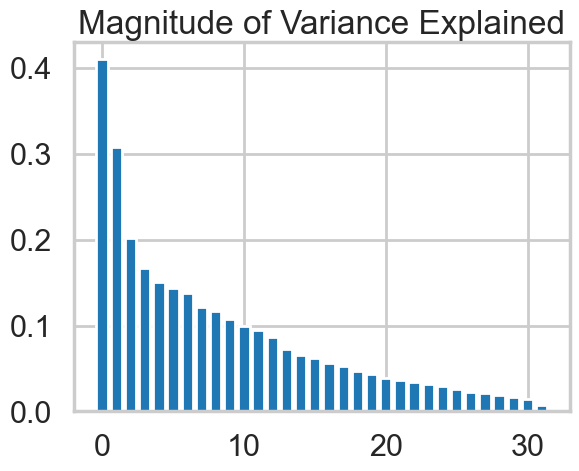

In [95]:
# Do the rest on your own :). That is to plot
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.title("Magnitude of Variance Explained")

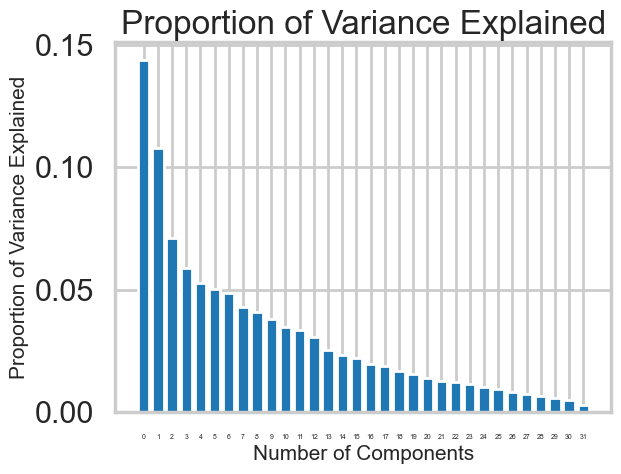

In [96]:
# Let's finish this :)  Make a variable called variance
variance = pca.explained_variance_ratio_

# Plot() it 
plt.bar(range(len(variance)), variance)

# Label the axes
plt.title("Proportion of Variance Explained")
plt.xlabel("Number of Components", size=15)
plt.ylabel("Proportion of Variance Explained", size=15)
plt.xticks(range(len(variance)), size=5);

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity propagation

In [97]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [101]:
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
#print(
#    "Silhouette Coefficient: %0.3f"
#    % metrics.silhouette_score(X, labels, metric="sqeuclidean")
#)

Estimated number of clusters: 1


In [104]:
# If cluster using all 32 features, we have 1 cluster.
# Let try clustering using the first two PCA features
af = AffinityPropagation(preference=-50, random_state=0).fit(transformed)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_) 

Estimated number of clusters: 1


In [103]:
transformed.shape

(100, 2)

### Spectral clustering

In [105]:
# Spectral clustering
from sklearn.cluster import SpectralClustering

In [106]:
sc = SpectralClustering(n_clusters=2).fit(X)
print(sc)

SpectralClustering(n_clusters=2)


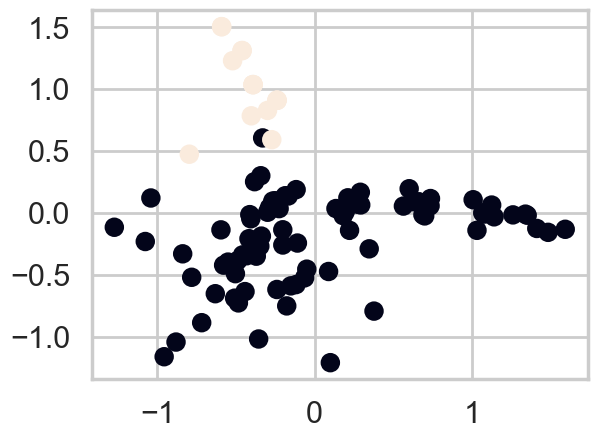

In [110]:
labels = sc.labels_
plt.scatter(transformed[:,0], transformed[:,1], c=labels)

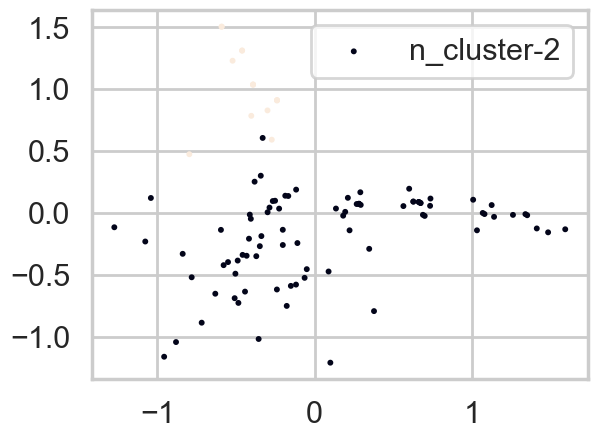

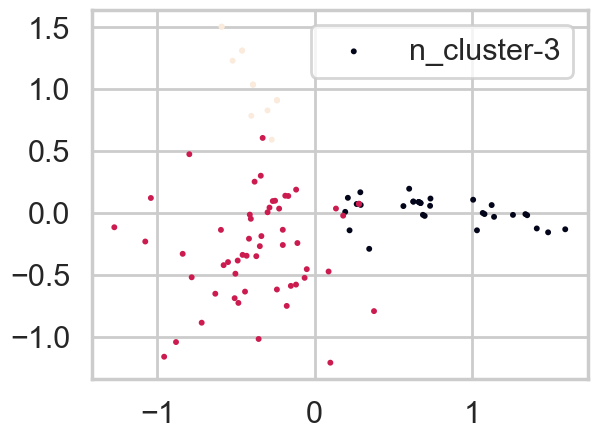

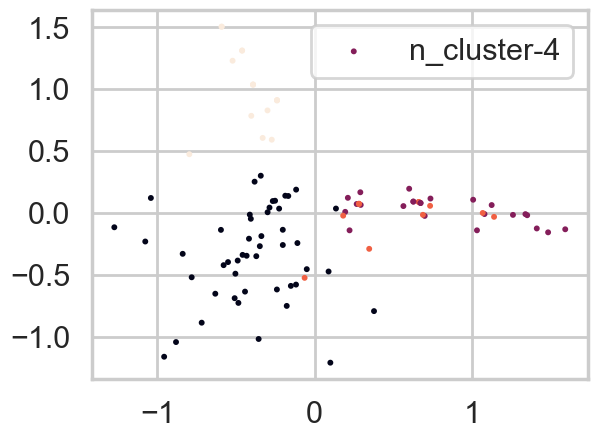

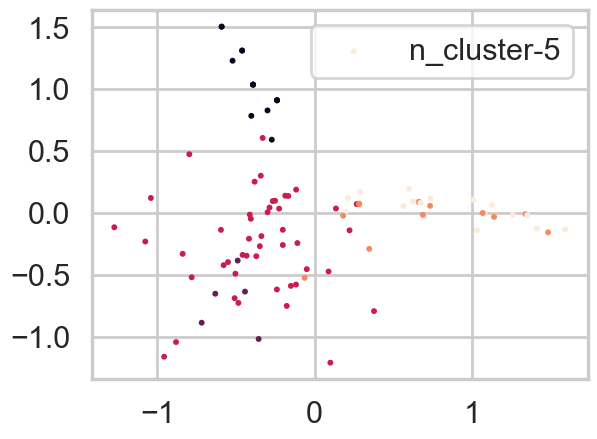

In [112]:
for i in range(2, 6):
    plt.figure(i)
    sc = SpectralClustering(n_clusters=i).fit(X)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
    plt.legend()

plt.show()

### Agglomerative clustering (using scipy)

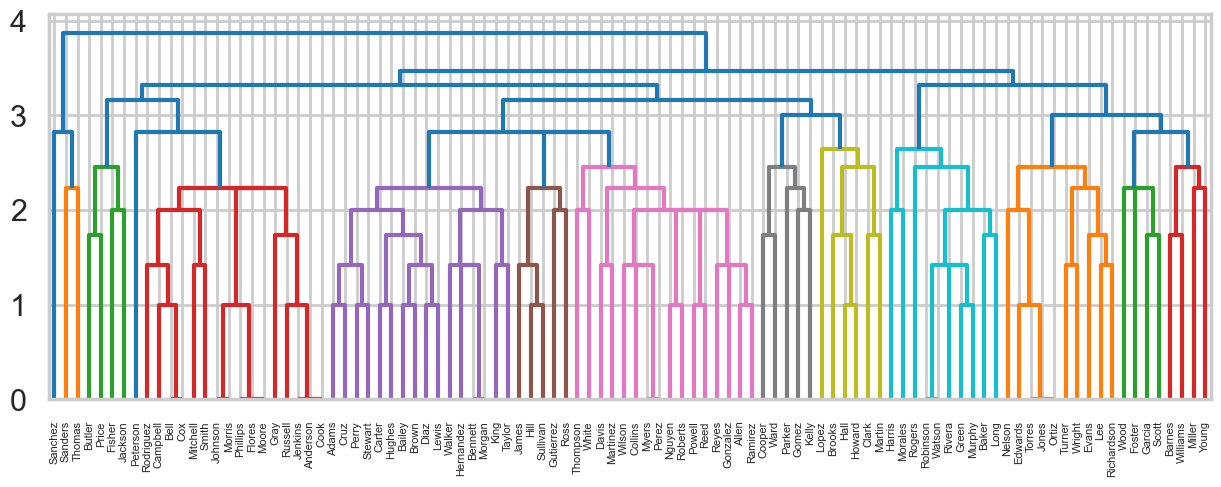

In [123]:
# Agglomerative clustering
from scipy.cluster.hierarchy import linkage, dendrogram
mergings = linkage(X, method='complete')
plt.figure(figsize=(15,5))
dendrogram(mergings, labels=pivoted.index, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [127]:
# Check if hierachical clustering is consistent with K-means of 3 
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2]), array([37, 47, 16], dtype=int64))

In [128]:
# Check if hierachical clustering is consistent with K-means of 5
model = sklearn.cluster.KMeans(n_clusters=5)
cluster_assignments = model.fit_predict(X)
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3, 4]), array([38,  3, 25, 18, 16], dtype=int64))

In [133]:
# Extract cluster labels from hierachical clustering
from scipy.cluster.hierarchy import fcluster
labels = fcluster(mergings, 3.2, criterion='distance')

In [134]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([ 3, 21, 48, 10, 18], dtype=int64))

### Agglomerative clustering (using sklearn)

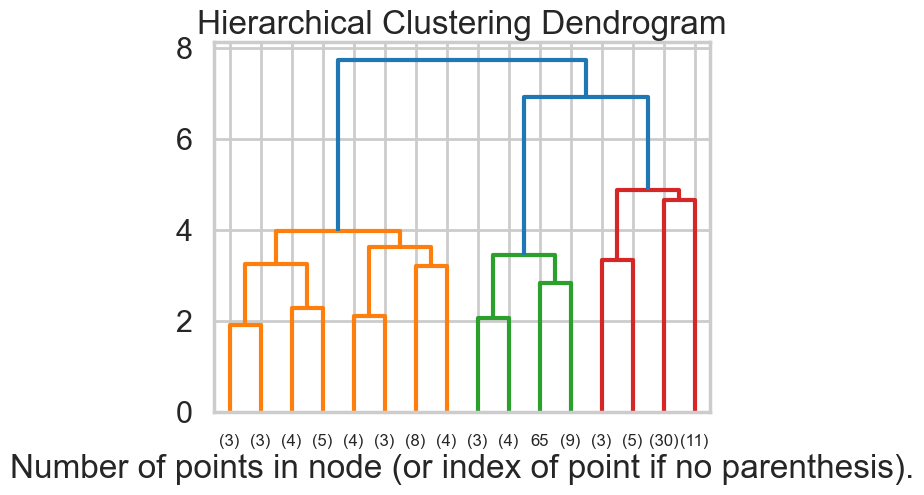

In [137]:
# Code modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

#import numpy as np

#from matplotlib import pyplot as plt
#from scipy.cluster.hierarchy import dendrogram
#from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
# default distance is 'ward'
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


### DBSCAN

In [139]:
# DBSCAN
# Code modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)

In [146]:
db = DBSCAN(eps=0.3, min_samples=3).fit(X_std)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 91
Silhouette Coefficient: -0.107
